# Classification models 
CDS Class, prepared by Prof. Dorien Herremans, Cheuk Kin Wai, and Yin-Jyun Luo. 


---






Let's start by loading the necessary libraries for this class. The main libraries used are numpy and pandas for data handling and [scikit learn (sklearn)](https://scikit-learn.org/stable/) for classification models. 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Walkthrough example of different classification methods

To become familiar with the classification models, please follow the instructions below. 

### Problem description and preparing dataset

Let's start doing some classification on the Heart Disease dataset from Kaggle at https://www.kaggle.com/ronitf/heart-disease-uci. The dataset has 303 patients and 13 features for each patient. 

You can find the dataset at the link above, or directly load it like shown below: 


In [2]:
data = pd.read_csv('heart.csv')
print(data.head())
print(data.shape)

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
(303, 14)


Let's make the data nicer. Since the column headers are a bit heard to read, we can override them to provide more easy to understand labels:

In [3]:
# Give a better name to each column
data.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

Let's check how balanced our dataset is. 

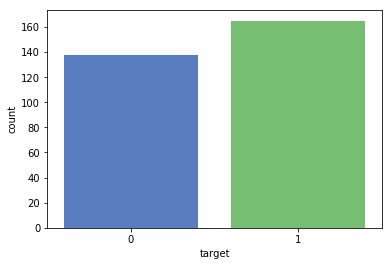

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="target",data=data,palette="muted")

It's almost balanced, but not entirely, so during evaluation, let's make sure to check F1 values and AUC instead of just accuracy. 

We also need to make sure that the system recognises our data as being categorical appropriately. 

In [5]:
data.dtypes

age                          int64
sex                          int64
chest_pain_type              int64
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar          int64
rest_ecg                     int64
max_heart_rate_achieved      int64
exercise_induced_angina      int64
st_depression              float64
st_slope                     int64
num_major_vessels            int64
thalassemia                  int64
target                       int64
dtype: object

This looks good. Everything is an integer, except for the continuous variables. In the case where categories are stored as strings, you need to correct this with: 

data['Class'] = pd.Categorical(data['Class'])

data['Class'] = data['Class'].cat.codes

In our case all is well. 

Looking at the header, the prediction task is now clear: we need to predict if target = 1, meaning heart disease is present. 

To properly evaluate models, we **create a test and training set** with 30% split using train_test_split. 

In [6]:
from sklearn.model_selection import train_test_split

Most classifiers will work best if the data is normalized. We can easily do this by using the MinMaxScaler fuction. 


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',1),data['target'],test_size=0.3,random_state=0)

### Normalizing

In [8]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
x_scaler.fit(X_train)
X_train_norm = x_scaler.transform(X_train)
X_test_norm = x_scaler.transform(X_test)

### Model 1: Decision Trees

Let's import the sklearn library for CART decision trees, and define a variable 'model' to hold our CART tree model. We can specify some pruning/early stopping parameters so that the size of the tree can be adjusted. 

In [9]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=1)

Let's train the model by passing it our training data X_train and labels y_train. Note that decision trees don't need normalized data, in this case it may be easier to understand with the original data (so we are using X_train, not X_train_norm as we do in the other models): 

In [10]:
model.fit(X_train,y_train) #training

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Notice how the options above let you tweek the classifier (e.g. criterion Gini coefficient). This model trained really fast! But how good is it?

I've emphasized the importance of evaluating models using multiple metrics in class. Let's **define a function called
evaluate_on_training_set, which will print out all of out metrics**. This will save us some time throughout the lab. 

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_on_training_set(y_test,y_pred):
    print("AUC is: " + str(roc_auc_score(y_test,y_pred)))
    print(classification_report(y_test,y_pred))
    print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    
    plt.plot(fpr,tpr,label = 'ROC curve (area %0.3f)'% roc_auc_score(y_test,y_pred))
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    

Using this new function we can now make predictions for our newly trained model 'model' and get the evaluation metrics: 


AUC is: 0.8104448742746615
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        44
           1       0.78      0.89      0.83        47

    accuracy                           0.81        91
   macro avg       0.82      0.81      0.81        91
weighted avg       0.82      0.81      0.81        91

Confusion Matrix: 
 [[32 12]
 [ 5 42]]


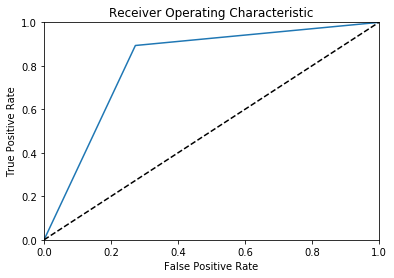

In [12]:
y_pred = model.predict(X_test)
evaluate_on_training_set(y_test,y_pred)

Finally, what does the actual tree look like? You can experiment yourself how the tree (and the accuracy) changes when we set different pruning parameters. 

[Text(394.1,1052.56,'X[2] <= 0.5\nentropy = 0.494\nsamples = 212\nvalue = [94, 118]'),
 Text(197.05,751.825,'X[11] <= 0.5\nentropy = 0.415\nsamples = 102\nvalue = [72, 30]'),
 Text(98.525,451.095,'X[12] <= 2.5\nentropy = 0.492\nsamples = 48\nvalue = [21, 27]'),
 Text(49.2625,150.365,'entropy = 0.328\nsamples = 29\nvalue = [6, 23]'),
 Text(147.788,150.365,'entropy = 0.332\nsamples = 19\nvalue = [15, 4]'),
 Text(295.575,451.095,'X[0] <= 63.5\nentropy = 0.105\nsamples = 54\nvalue = [51, 3]'),
 Text(246.312,150.365,'entropy = 0.0\nsamples = 43\nvalue = [43, 0]'),
 Text(344.838,150.365,'entropy = 0.397\nsamples = 11\nvalue = [8, 3]'),
 Text(591.15,751.825,'X[9] <= 1.95\nentropy = 0.32\nsamples = 110\nvalue = [22, 88]'),
 Text(492.625,451.095,'X[7] <= 152.5\nentropy = 0.255\nsamples = 100\nvalue = [15, 85]'),
 Text(443.363,150.365,'entropy = 0.438\nsamples = 34\nvalue = [11, 23]'),
 Text(541.888,150.365,'entropy = 0.114\nsamples = 66\nvalue = [4, 62]'),
 Text(689.675,451.095,'X[10] <= 0.5\ne

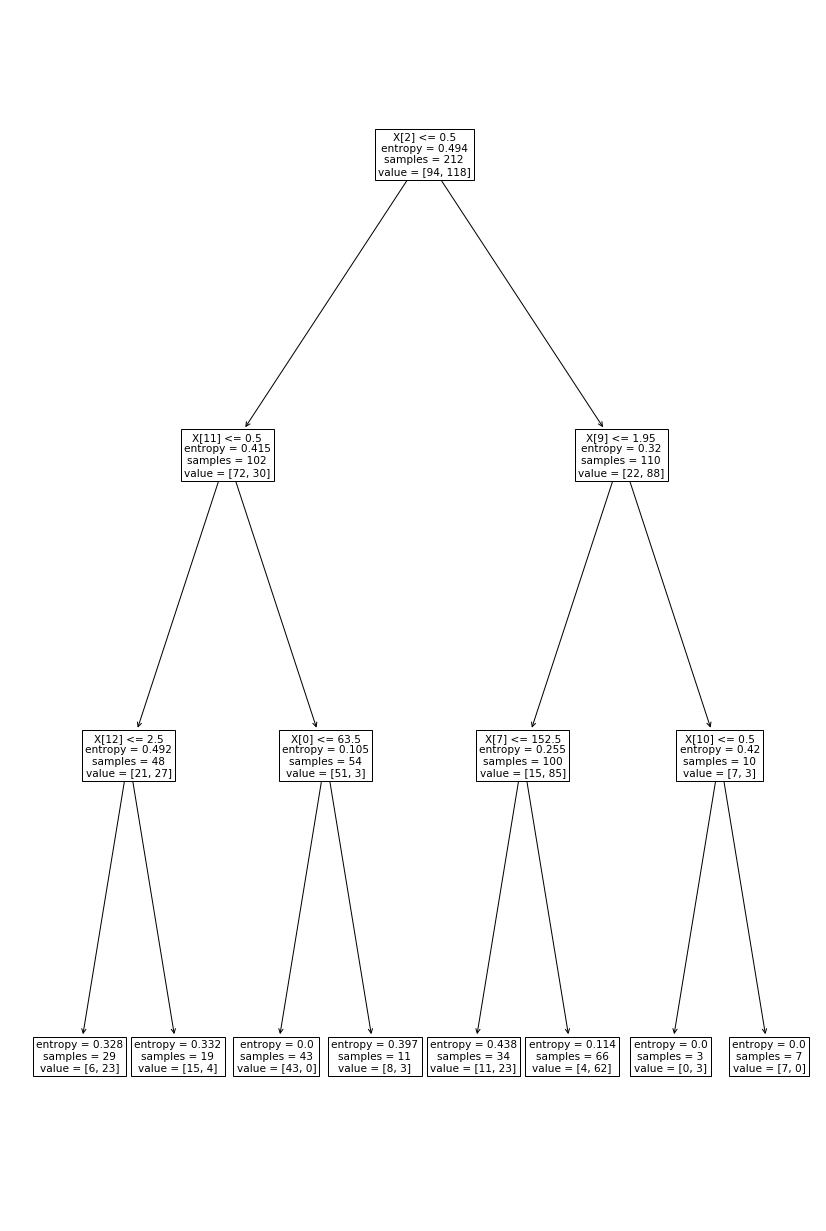

In [13]:
plt.figure(figsize=(14,22))
tree.plot_tree(model)

### Model 2: K Nearest Neighbor Classifier

Let's explore the kNN algorithm. As you've seen in class. It's a very simple algorithm, however, it needs a lot of time to compute all distances. 

Similar to before, we first load the library and define the model with parameters (here only the parameter k is needed). 

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=20) 
model.fit(X_train_norm,y_train)



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

We can then proceed to train the model using the fit command and evaluate it using the function we defined before: 

AUC is: 0.7202611218568665
              precision    recall  f1-score   support

           0       0.81      0.57      0.67        44
           1       0.68      0.87      0.77        47

    accuracy                           0.73        91
   macro avg       0.74      0.72      0.72        91
weighted avg       0.74      0.73      0.72        91

Confusion Matrix: 
 [[25 19]
 [ 6 41]]


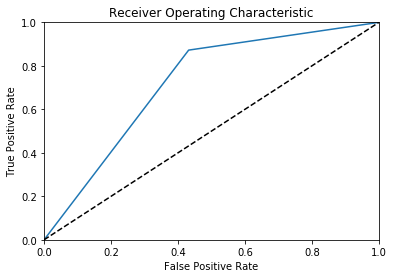

In [15]:
y_pred = model.predict(X_test_norm)
evaluate_on_training_set(y_test,y_pred)

It's extremely important to set a good value for k, so you will need to test this. E.g. try running the above code with k = 5. See any change? Your F1 scores should go up! 

### Model 3: Logistic Regression

Let's move on to a very powerful, yet fast model: Logistic Regression. Again, we start by loading the library and defining the model together with its parameters. 

In this case, multi_class auto will detect the number of classes automatically, C is our regularisation parameter, and solver is the optimization algorithm used to fit the model: 
* For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
* For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
* ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
* ‘liblinear’ and ‘saga’ also handle L1 penalty
* ‘saga’ also supports ‘elasticnet’ penalty
* ‘liblinear’ does not handle no penalty

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1.0,multi_class='auto',solver='lbfgs')


We can the train and evaluate the model like usual: 

AUC is: 0.7884429400386848
              precision    recall  f1-score   support

           0       0.84      0.70      0.77        44
           1       0.76      0.87      0.81        47

    accuracy                           0.79        91
   macro avg       0.80      0.79      0.79        91
weighted avg       0.80      0.79      0.79        91

Confusion Matrix: 
 [[31 13]
 [ 6 41]]


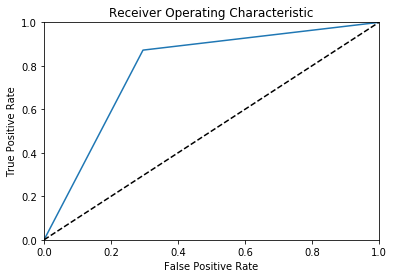

In [17]:
model.fit(X_train_norm,y_train)
y_pred = model.predict(X_test_norm)
evaluate_on_training_set(y_test,y_pred)

This is a fast model again, with rather good output. 

### Model 4: Gaussian Naive Bayes

Let's create a Naive Bayes model. There are a [number of variants on this model to choose](https://scikit-learn.org/stable/modules/naive_bayes.html) from in Scikit learn, let's pick the Gaussian variant. Same thing as always, we load the library and define the model: 

In [19]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

We can proceed to train (fit) the model and evaluate: 

AUC is: 0.799806576402321
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        44
           1       0.77      0.87      0.82        47

    accuracy                           0.80        91
   macro avg       0.81      0.80      0.80        91
weighted avg       0.81      0.80      0.80        91

Confusion Matrix: 
 [[32 12]
 [ 6 41]]


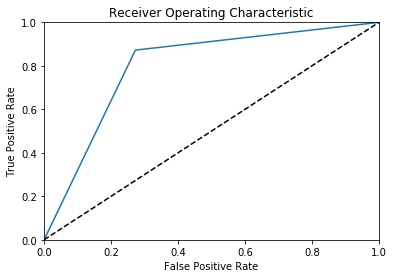

In [20]:
model.fit(X_train_norm,y_train)
y_pred = model.predict(X_test_norm)
evaluate_on_training_set(y_test,y_pred)

Not a bad result! Gaussian models often perform well with smaller datasets as they fit the limited data to a distribution. 

### Model 5: SVM

Support Vector Machines offer a very powerful way to transform our data by implementing a 'kernel trick'. Hence, when we define our model, we need to specify our kernel. The results will be highly dependant on the kernel value and the regularisation parameter C. 

The kernel can be: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’. If none is given, ‘rbf’ will be used.

In [21]:
from sklearn.svm import SVC
model = SVC(C=10,gamma='auto',kernel='rbf')
model.fit(X_train_norm,y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

As usual, we use the exact same commands to train and evaluate the model: 

AUC is: 0.7983558994197292
              precision    recall  f1-score   support

           0       0.88      0.68      0.77        44
           1       0.75      0.91      0.83        47

    accuracy                           0.80        91
   macro avg       0.82      0.80      0.80        91
weighted avg       0.82      0.80      0.80        91

Confusion Matrix: 
 [[30 14]
 [ 4 43]]


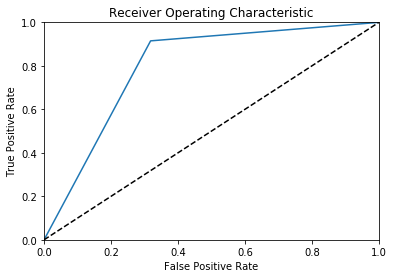

In [22]:
model.fit(X_train_norm,y_train)

y_pred = model.predict(X_test_norm)
evaluate_on_training_set(y_test,y_pred)

##### optimizing SVM using GridSearch 
Were you expecting better results from such a powerful model? Let's tweek the parameters to improve our accuracy...

We will be using Grid Search to tune parameters and try a range: 
- with kernel rbf, try varying gamma (which is a coefficient in the rbf kernel) to be 1e-3 or 1e-4; and vary C to be 1, 10, or 100.
- with linear kernel (there is no gamma here), try varying C to be 1, 10, and 100.

These values are stored as tuned_parameters. 

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

tuned_parameters= [{'kernel':['rbf'],'gamma':[1e-3,1e-4],'C':[1,10,100]},{'kernel':['linear'],'C':[1,10,100]}]

Using the above parameters, we can run a GridSearch algorithm to optimize the AUC score. The verbose output will output the process; n_jobs will parallize the computation over 4 processors; 2-fold CV is used during the search (cv = 2). 

In [24]:
clf = GridSearchCV(SVC(),tuned_parameters,cv=2,scoring='roc_auc',verbose=1,n_jobs=4)
clf.fit(X_train_norm,y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    4.1s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=4,
             param_grid=[{'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

Once this is trained we can again look at what the best parameters are and how well the model performs. 

Best permeter set found on dev set: 
{'C': 10, 'kernel': 'linear'} 

AUC is: 0.8210831721470019
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        44
           1       0.78      0.91      0.84        47

    accuracy                           0.82        91
   macro avg       0.84      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91

Confusion Matrix: 
 [[32 12]
 [ 4 43]]


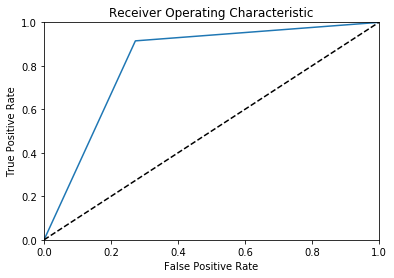

In [26]:
# Show best params
print("Best permeter set found on dev set: ")
print(clf.best_params_,'\n')

y_pred = clf.predict(X_test_norm)
evaluate_on_training_set(y_test,y_pred)

### Model 5: AdaBoostClassifier (Ensemble method)

Ensemble models such as AdaBoost build multiple models and leverage the output to get a better result (most of the time). Sklearn tells us that: "AdaBoost is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases."

Let's define our model and set some parameters, learning rate can vary from 0 to 1; and n_estimators is the number of times a model is built. 

In [30]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=1000,learning_rate=0.1)

How does it perform? 

AUC is: 0.8239845261121856
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        44
           1       0.83      0.83      0.83        47

    accuracy                           0.82        91
   macro avg       0.82      0.82      0.82        91
weighted avg       0.82      0.82      0.82        91

Confusion Matrix: 
 [[36  8]
 [ 8 39]]


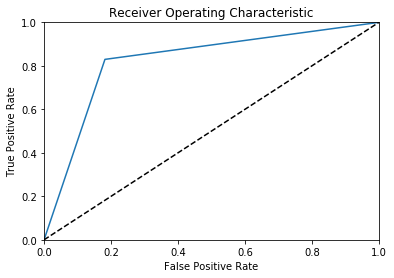

In [34]:
model.fit(X_train_norm,y_train)

y_pred = model.predict(X_test_norm)
evaluate_on_training_set(y_test,y_pred)

### Model 6: RandomForestClassifier

Another ensemble classifier is Random Forest, which takes a bagging approach. We define the model: 

In [35]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50)

You can experiment with the parameters above (n_estimators is how many trees there are in the model), until you get good results. More parameters about the trees can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

AUC is: 0.8218085106382979
              precision    recall  f1-score   support

           0       0.87      0.75      0.80        44
           1       0.79      0.89      0.84        47

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91

Confusion Matrix: 
 [[33 11]
 [ 5 42]]


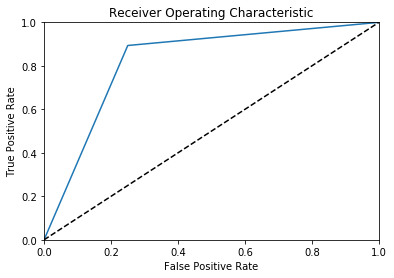

In [36]:
model.fit(X_train_norm,y_train)
y_pred = model.predict(X_test_norm)
evaluate_on_training_set(y_test,y_pred)

This is an excellent model and trained quite fast. 

# Let's try on a new dataset...

Find the best performing model to predict student's academic performance and the following dataset: https://www.kaggle.com/aljarah/xAPI-Edu-Data. The goal is to estimate the grade level of the student: 

The students are grouped into three numerical intervals based on their total grade/mark:
* Low-Level: interval includes values from 0 to 69,
* Middle-Level: interval includes values from 70 to 89,
* High-Level: interval includes values from 90-100.

Some steps for you to follow: 

1. Load the csv file as dataframe directly from

 https://dorienherremans.com/drop/CDS/classification/xAPI-Edu-Data.csv
2. Check if columns are recognised as categorical, is not, change them to categorical with the command: 

for key in ['gender','NationalITy','PlaceofBirth','StageID','GradeID','SectionID','Topic','Semester',
'Relation',

'ParentAnsweringSurvey','ParentschoolSatisfaction',
'StudentAbsenceDays','Class']:

    data[key] = pd.Categorical(data[key])
    data[key] = data[key].cat.codes

3. Preprocess the data to create a normalized training set with 30% split.
4. Train and evaluate multiple models to find the best classifier. 

IMPORTANT: Evaluate **only** in terms of classification_report and confusion matrix. (No need for AUC and ROC here, as we are doing multiclass classification, the target label would need to be binarized first, which we are not doing.)

We are trying to reach the **best recall performance** for predicting high grade students (class 0), in other words: number of correctly predicted high grade students over the total number of high grade students. 

**Fill in your best performing recall score for class 0 in our high score list: 
https://forms.gle/wquRxxjVBfgnVtht8**


In [39]:
data = pd.read_csv('xAPI-EDU-DATA.csv')
print(data.head())
print(data.shape)

data.dtypes

  gender NationalITy PlaceofBirth     StageID GradeID SectionID Topic  \
0      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
1      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
2      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
3      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
4      M          KW       KuwaIT  lowerlevel    G-04         A    IT   

  Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
0        F   Father           15                16                  2   
1        F   Father           20                20                  3   
2        F   Father           10                 7                  0   
3        F   Father           30                25                  5   
4        F   Father           40                50                 12   

   Discussion ParentAnsweringSurvey ParentschoolSatisfaction  \
0          20                   Yes                     Go

gender                      object
NationalITy                 object
PlaceofBirth                object
StageID                     object
GradeID                     object
SectionID                   object
Topic                       object
Semester                    object
Relation                    object
raisedhands                  int64
VisITedResources             int64
AnnouncementsView            int64
Discussion                   int64
ParentAnsweringSurvey       object
ParentschoolSatisfaction    object
StudentAbsenceDays          object
Class                       object
dtype: object

Helpful code to categorise the attributes (and save you typing time): 

In [41]:
for key in ['gender','NationalITy','PlaceofBirth','StageID','GradeID','SectionID','Topic','Semester','Relation','ParentAnsweringSurvey','ParentschoolSatisfaction','StudentAbsenceDays','Class']:

    data[key] = pd.Categorical(data[key])
    data[key] = data[key].cat.codes

data.head()
data.dtypes

gender                       int8
NationalITy                  int8
PlaceofBirth                 int8
StageID                      int8
GradeID                      int8
SectionID                    int8
Topic                        int8
Semester                     int8
Relation                     int8
raisedhands                 int64
VisITedResources            int64
AnnouncementsView           int64
Discussion                  int64
ParentAnsweringSurvey        int8
ParentschoolSatisfaction     int8
StudentAbsenceDays           int8
Class                        int8
dtype: object

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Class',1),data['Class'],test_size=0.3,random_state=0)

x_scaler = MinMaxScaler()
x_scaler.fit(X_train)
X_train_norm = x_scaler.transform(X_train)
X_test_norm = x_scaler.transform(X_test)


In [102]:
def evaluate_multi_class_on_training_set(y_test,y_pred):
    #print("AUC is: " + str(roc_auc_score(y_test,y_pred)))
    print(classification_report(y_test,y_pred))
    print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
    
    #fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    
    #plt.plot(fpr,tpr,label = 'ROC curve (area %0.3f)'% roc_auc_score(y_test,y_pred))
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

              precision    recall  f1-score   support

           0       0.44      0.95      0.60        39
           1       0.53      0.94      0.68        34
           2       0.00      0.00      0.00        71

    accuracy                           0.48       144
   macro avg       0.32      0.63      0.43       144
weighted avg       0.25      0.48      0.32       144

Confusion Matrix: 
 [[37  2  0]
 [ 2 32  0]
 [45 26  0]]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


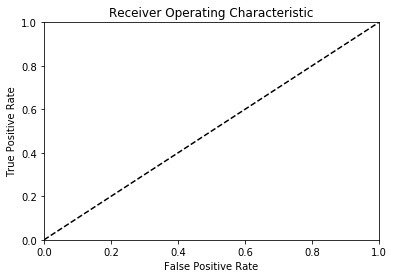

In [105]:
model = AdaBoostClassifier(n_estimators=1,learning_rate=0.1)
model.fit(X_train_norm,y_train)



y_pred = model.predict(X_test_norm)
evaluate_multi_class_on_training_set(y_test,y_pred)